In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_22_1 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 1
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_22_1[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 72.64414739608765 
    loop_MC 1 - time has passed: 144.22473216056824 
    loop_MC 2 - time has passed: 213.5258755683899 
    loop_MC 3 - time has passed: 282.1758818626404 
    loop_MC 4 - time has passed: 351.19350695610046 
    loop_MC 5 - time has passed: 421.7838978767395 
    loop_MC 6 - time has passed: 491.1832675933838 
    loop_MC 7 - time has passed: 559.7100415229797 
    loop_MC 8 - time has passed: 629.0470471382141 
    loop_MC 9 - time has passed: 697.4796597957611 
    loop_MC 10 - time has passed: 766.9956467151642 
    loop_MC 11 - time has passed: 835.9692935943604 
    loop_MC 12 - time has passed: 903.3516721725464 
    loop_MC 13 - time has passed: 971.8718938827515 
    loop_MC 14 - time has passed: 1039.9875779151917 
    loop_MC 15 - time has passed: 1110.4924292564392 
    loop_MC 16 - time has passed: 1178.9045641422272 
    loop_MC 17 - time has passed: 1246.912679195404 
    loop_MC 18 - time has passed: 1315.366710901260

    loop_MC 2 - time has passed: 192.6793577671051 
    loop_MC 3 - time has passed: 249.26245594024658 
    loop_MC 4 - time has passed: 305.7983720302582 
    loop_MC 5 - time has passed: 373.1899528503418 
    loop_MC 6 - time has passed: 441.7849681377411 
    loop_MC 7 - time has passed: 510.2495586872101 
    loop_MC 8 - time has passed: 578.5322504043579 
    loop_MC 9 - time has passed: 645.9380965232849 
    loop_MC 10 - time has passed: 714.1450605392456 
    loop_MC 11 - time has passed: 771.2959289550781 
    loop_MC 12 - time has passed: 839.3326025009155 
    loop_MC 13 - time has passed: 906.6677825450897 
    loop_MC 14 - time has passed: 974.6240463256836 
    loop_MC 15 - time has passed: 1042.5631783008575 
    loop_MC 16 - time has passed: 1110.2076833248138 
    loop_MC 17 - time has passed: 1177.0901093482971 
    loop_MC 18 - time has passed: 1244.2962274551392 
    loop_MC 19 - time has passed: 1312.9085829257965 
    loop_MC 20 - time has passed: 1379.856864452

    loop_MC 3 - time has passed: 259.85089325904846 
    loop_MC 4 - time has passed: 328.08142042160034 
    loop_MC 5 - time has passed: 396.36243987083435 
    loop_MC 6 - time has passed: 463.40880131721497 
    loop_MC 7 - time has passed: 530.5864505767822 
    loop_MC 8 - time has passed: 597.5610387325287 
    loop_MC 9 - time has passed: 665.1744966506958 
    loop_MC 10 - time has passed: 733.0296692848206 
    loop_MC 11 - time has passed: 799.7828540802002 
    loop_MC 12 - time has passed: 866.7806553840637 
    loop_MC 13 - time has passed: 934.667366027832 
    loop_MC 14 - time has passed: 1002.7199954986572 
    loop_MC 15 - time has passed: 1070.4535827636719 
    loop_MC 16 - time has passed: 1138.1761629581451 
    loop_MC 17 - time has passed: 1194.4899702072144 
    loop_MC 18 - time has passed: 1262.2131235599518 
    loop_MC 19 - time has passed: 1329.9702219963074 
    loop_MC 20 - time has passed: 1396.9135472774506 
    loop_MC 21 - time has passed: 1465.2189

    loop_MC 4 - time has passed: 338.1817367076874 
    loop_MC 5 - time has passed: 406.353631734848 
    loop_MC 6 - time has passed: 462.387060880661 
    loop_MC 7 - time has passed: 529.7666275501251 
    loop_MC 8 - time has passed: 596.6739153862 
    loop_MC 9 - time has passed: 665.3101036548615 
    loop_MC 10 - time has passed: 733.0926606655121 
    loop_MC 11 - time has passed: 801.1284394264221 
    loop_MC 12 - time has passed: 868.3772439956665 
    loop_MC 13 - time has passed: 935.9843032360077 
    loop_MC 14 - time has passed: 1004.3236498832703 
    loop_MC 15 - time has passed: 1072.6893048286438 
    loop_MC 16 - time has passed: 1139.9573166370392 
    loop_MC 17 - time has passed: 1207.7628207206726 
    loop_MC 18 - time has passed: 1275.563142299652 
    loop_MC 19 - time has passed: 1331.357536315918 
    loop_MC 20 - time has passed: 1398.925583600998 
    loop_MC 21 - time has passed: 1466.351016998291 
    loop_MC 22 - time has passed: 1534.0091333389282 

    loop_MC 6 - time has passed: 476.3820013999939 
    loop_MC 7 - time has passed: 544.4670026302338 
    loop_MC 8 - time has passed: 612.9591009616852 
    loop_MC 9 - time has passed: 680.7462522983551 
    loop_MC 10 - time has passed: 737.1084716320038 
    loop_MC 11 - time has passed: 805.3895390033722 
    loop_MC 12 - time has passed: 873.7955300807953 
    loop_MC 13 - time has passed: 942.0914742946625 
    loop_MC 14 - time has passed: 1009.9191315174103 
    loop_MC 15 - time has passed: 1066.1095781326294 
    loop_MC 16 - time has passed: 1133.5498838424683 
    loop_MC 17 - time has passed: 1201.5859429836273 
    loop_MC 18 - time has passed: 1269.607521057129 
    loop_MC 19 - time has passed: 1337.019320011139 
    loop_MC 20 - time has passed: 1404.6392290592194 
    loop_MC 21 - time has passed: 1472.1754312515259 
    loop_MC 22 - time has passed: 1540.358875989914 
    loop_MC 23 - time has passed: 1608.258740901947 
    loop_MC 24 - time has passed: 1675.76872

    loop_MC 7 - time has passed: 528.1100420951843 
    loop_MC 8 - time has passed: 595.7818689346313 
    loop_MC 9 - time has passed: 663.6571238040924 
    loop_MC 10 - time has passed: 732.0470006465912 
    loop_MC 11 - time has passed: 799.5243480205536 
    loop_MC 12 - time has passed: 866.7981803417206 
    loop_MC 13 - time has passed: 934.943585395813 
    loop_MC 14 - time has passed: 1002.8133025169373 
    loop_MC 15 - time has passed: 1070.4000408649445 
    loop_MC 16 - time has passed: 1138.100145816803 
    loop_MC 17 - time has passed: 1206.3652648925781 
    loop_MC 18 - time has passed: 1274.0044255256653 
    loop_MC 19 - time has passed: 1341.6906673908234 
    loop_MC 20 - time has passed: 1409.281282901764 
    loop_MC 21 - time has passed: 1477.2262618541718 
    loop_MC 22 - time has passed: 1544.5226037502289 
    loop_MC 23 - time has passed: 1611.9707384109497 
    loop_MC 24 - time has passed: 1680.0494542121887 
    loop_MC 25 - time has passed: 1746.95

    loop_MC 9 - time has passed: 676.0346715450287 
    loop_MC 10 - time has passed: 743.8571689128876 
    loop_MC 11 - time has passed: 810.4062654972076 
    loop_MC 12 - time has passed: 877.9753577709198 
    loop_MC 13 - time has passed: 945.8480942249298 
    loop_MC 14 - time has passed: 1012.8712077140808 
    loop_MC 15 - time has passed: 1079.8531651496887 
    loop_MC 16 - time has passed: 1146.7350769042969 
    loop_MC 17 - time has passed: 1214.5069456100464 
    loop_MC 18 - time has passed: 1282.440299987793 
    loop_MC 19 - time has passed: 1349.532172203064 
    loop_MC 20 - time has passed: 1417.0318143367767 
    loop_MC 21 - time has passed: 1484.8013167381287 
    loop_MC 22 - time has passed: 1552.3351905345917 
    loop_MC 23 - time has passed: 1619.5794780254364 
    loop_MC 24 - time has passed: 1686.6077072620392 
    loop_MC 25 - time has passed: 1753.9603860378265 
    loop_MC 26 - time has passed: 1821.2815465927124 
    loop_MC 27 - time has passed: 18

    loop_MC 10 - time has passed: 730.4197299480438 
    loop_MC 11 - time has passed: 797.9980676174164 
    loop_MC 12 - time has passed: 865.2999017238617 
    loop_MC 13 - time has passed: 932.7120983600616 
    loop_MC 14 - time has passed: 1000.0430066585541 
    loop_MC 15 - time has passed: 1068.2887563705444 
    loop_MC 16 - time has passed: 1135.919687986374 
    loop_MC 17 - time has passed: 1203.13312292099 
    loop_MC 18 - time has passed: 1270.6339011192322 
    loop_MC 19 - time has passed: 1337.4401593208313 
    loop_MC 20 - time has passed: 1404.4063427448273 
    loop_MC 21 - time has passed: 1471.841656446457 
    loop_MC 22 - time has passed: 1538.3536977767944 
    loop_MC 23 - time has passed: 1606.2478897571564 
    loop_MC 24 - time has passed: 1674.0086901187897 
    loop_MC 25 - time has passed: 1741.6727488040924 
    loop_MC 26 - time has passed: 1809.4778227806091 
    loop_MC 27 - time has passed: 1876.5150256156921 
    loop_MC 28 - time has passed: 19

    loop_MC 11 - time has passed: 807.5387454032898 
    loop_MC 12 - time has passed: 875.555422782898 
    loop_MC 13 - time has passed: 943.8688735961914 
    loop_MC 14 - time has passed: 1010.7283790111542 
    loop_MC 15 - time has passed: 1077.6788778305054 
    loop_MC 16 - time has passed: 1144.726788520813 
    loop_MC 17 - time has passed: 1212.3846135139465 
    loop_MC 18 - time has passed: 1279.7089450359344 
    loop_MC 19 - time has passed: 1347.0860042572021 
    loop_MC 20 - time has passed: 1414.6488740444183 
    loop_MC 21 - time has passed: 1482.0268301963806 
    loop_MC 22 - time has passed: 1549.4144897460938 
    loop_MC 23 - time has passed: 1615.866043329239 
    loop_MC 24 - time has passed: 1682.8497335910797 
    loop_MC 25 - time has passed: 1750.5325491428375 
    loop_MC 26 - time has passed: 1817.6470911502838 
    loop_MC 27 - time has passed: 1885.6324231624603 
    loop_MC 28 - time has passed: 1952.6802852153778 
    loop_MC 29 - time has passed: 

    loop_MC 13 - time has passed: 944.738089799881 
    loop_MC 14 - time has passed: 1012.1712784767151 
    loop_MC 15 - time has passed: 1079.1444375514984 
    loop_MC 16 - time has passed: 1145.4399011135101 
    loop_MC 17 - time has passed: 1212.1412801742554 
    loop_MC 18 - time has passed: 1280.064618587494 
    loop_MC 19 - time has passed: 1348.0503039360046 
    loop_MC 20 - time has passed: 1415.3808236122131 
    loop_MC 21 - time has passed: 1482.0485475063324 
    loop_MC 22 - time has passed: 1549.3736371994019 
    loop_MC 23 - time has passed: 1616.3490550518036 
    loop_MC 24 - time has passed: 1684.4275209903717 
    loop_MC 25 - time has passed: 1751.6484382152557 
    loop_MC 26 - time has passed: 1819.5046746730804 
    loop_MC 27 - time has passed: 1887.0998315811157 
    loop_MC 28 - time has passed: 1953.6189749240875 
    loop_MC 29 - time has passed: 2021.392998456955 
    loop_MC 30 - time has passed: 2088.690686941147 
    loop_MC 31 - time has passed:

    loop_MC 14 - time has passed: 1011.7397763729095 
    loop_MC 15 - time has passed: 1078.7467060089111 
    loop_MC 16 - time has passed: 1145.9861814975739 
    loop_MC 17 - time has passed: 1213.1149954795837 
    loop_MC 18 - time has passed: 1280.1391818523407 
    loop_MC 19 - time has passed: 1347.1433539390564 
    loop_MC 20 - time has passed: 1414.3153991699219 
    loop_MC 21 - time has passed: 1481.138597726822 
    loop_MC 22 - time has passed: 1548.945251941681 
    loop_MC 23 - time has passed: 1616.2198560237885 
    loop_MC 24 - time has passed: 1682.9107718467712 
    loop_MC 25 - time has passed: 1749.2895920276642 
    loop_MC 26 - time has passed: 1816.0192966461182 
    loop_MC 27 - time has passed: 1882.4369084835052 
    loop_MC 28 - time has passed: 1949.5816571712494 
    loop_MC 29 - time has passed: 2016.8903994560242 
    loop_MC 30 - time has passed: 2083.515016555786 
    loop_MC 31 - time has passed: 2150.8570153713226 
    loop_MC 32 - time has passe

    loop_MC 15 - time has passed: 1073.9655554294586 
    loop_MC 16 - time has passed: 1140.9686617851257 
    loop_MC 17 - time has passed: 1208.1351211071014 
    loop_MC 18 - time has passed: 1275.5347714424133 
    loop_MC 19 - time has passed: 1342.547649860382 
    loop_MC 20 - time has passed: 1410.0187873840332 
    loop_MC 21 - time has passed: 1477.2076878547668 
    loop_MC 22 - time has passed: 1544.4608974456787 
    loop_MC 23 - time has passed: 1611.5677382946014 
    loop_MC 24 - time has passed: 1679.0772500038147 
    loop_MC 25 - time has passed: 1746.5507423877716 
    loop_MC 26 - time has passed: 1813.6761946678162 
    loop_MC 27 - time has passed: 1880.7666158676147 
    loop_MC 28 - time has passed: 1947.9983756542206 
    loop_MC 29 - time has passed: 2015.0618698596954 
    loop_MC 30 - time has passed: 2082.7193217277527 
    loop_MC 31 - time has passed: 2150.097252845764 
    loop_MC 32 - time has passed: 2216.6856048107147 
    loop_MC 33 - time has pass

    loop_MC 16 - time has passed: 1009.205100774765 
    loop_MC 17 - time has passed: 1062.9573411941528 
    loop_MC 18 - time has passed: 1116.4667155742645 
    loop_MC 19 - time has passed: 1170.1543188095093 
    loop_MC 20 - time has passed: 1226.4922873973846 
    loop_MC 21 - time has passed: 1283.73845744133 
    loop_MC 22 - time has passed: 1337.835078716278 
    loop_MC 23 - time has passed: 1391.8453900814056 
    loop_MC 24 - time has passed: 1445.8475368022919 
    loop_MC 25 - time has passed: 1499.5155656337738 
    loop_MC 26 - time has passed: 1553.3368401527405 
    loop_MC 27 - time has passed: 1607.2729041576385 
    loop_MC 28 - time has passed: 1661.3410148620605 
    loop_MC 29 - time has passed: 1715.0816714763641 
    loop_MC 30 - time has passed: 1768.8404347896576 
    loop_MC 31 - time has passed: 1822.6636471748352 
    loop_MC 32 - time has passed: 1876.5294721126556 
    loop_MC 33 - time has passed: 1930.4140145778656 
    loop_MC 34 - time has passed

    loop_MC 18 - time has passed: 1020.608304977417 
    loop_MC 19 - time has passed: 1074.0350413322449 
    loop_MC 20 - time has passed: 1127.6139295101166 
    loop_MC 21 - time has passed: 1176.4837872982025 
    loop_MC 22 - time has passed: 1218.936725139618 
    loop_MC 23 - time has passed: 1260.8281209468842 
    loop_MC 24 - time has passed: 1302.6244149208069 
    loop_MC 25 - time has passed: 1345.561830997467 
    loop_MC 26 - time has passed: 1390.2651703357697 
    loop_MC 27 - time has passed: 1434.4839634895325 
    loop_MC 28 - time has passed: 1477.8389177322388 
    loop_MC 29 - time has passed: 1521.3902144432068 
    loop_MC 30 - time has passed: 1564.5601651668549 
    loop_MC 31 - time has passed: 1606.4215154647827 
    loop_MC 32 - time has passed: 1648.7179338932037 
    loop_MC 33 - time has passed: 1693.6244797706604 
    loop_MC 34 - time has passed: 1734.9836513996124 
    loop_MC 35 - time has passed: 1779.5301990509033 
    loop_MC 36 - time has passe

    loop_MC 20 - time has passed: 904.6725137233734 
    loop_MC 21 - time has passed: 944.6829557418823 
    loop_MC 22 - time has passed: 988.2814002037048 
    loop_MC 23 - time has passed: 1031.0464808940887 
    loop_MC 24 - time has passed: 1072.2976298332214 
    loop_MC 25 - time has passed: 1114.3529162406921 
    loop_MC 26 - time has passed: 1157.4224417209625 
    loop_MC 27 - time has passed: 1200.9848186969757 
    loop_MC 28 - time has passed: 1243.2647914886475 
    loop_MC 29 - time has passed: 1285.9527990818024 
    loop_MC 30 - time has passed: 1329.14119887352 
    loop_MC 31 - time has passed: 1373.3443298339844 
    loop_MC 32 - time has passed: 1414.7349536418915 
    loop_MC 33 - time has passed: 1458.0006279945374 
    loop_MC 34 - time has passed: 1500.5744771957397 
    loop_MC 35 - time has passed: 1541.9372053146362 
    loop_MC 36 - time has passed: 1583.4849944114685 
    loop_MC 37 - time has passed: 1624.702806711197 
    loop_MC 38 - time has passed: 

    loop_MC 22 - time has passed: 750.7509880065918 
    loop_MC 23 - time has passed: 782.8919105529785 
    loop_MC 24 - time has passed: 815.4214298725128 
    loop_MC 25 - time has passed: 847.6098935604095 
    loop_MC 26 - time has passed: 880.282071352005 
    loop_MC 27 - time has passed: 912.6726732254028 
    loop_MC 28 - time has passed: 945.844676733017 
    loop_MC 29 - time has passed: 978.1882934570312 
    loop_MC 30 - time has passed: 1013.340300321579 
    loop_MC 31 - time has passed: 1047.5317132472992 
    loop_MC 32 - time has passed: 1080.3591005802155 
    loop_MC 33 - time has passed: 1113.0637679100037 
    loop_MC 34 - time has passed: 1145.485013961792 
    loop_MC 35 - time has passed: 1178.9487190246582 
    loop_MC 36 - time has passed: 1211.579022884369 
    loop_MC 37 - time has passed: 1244.141949892044 
    loop_MC 38 - time has passed: 1277.3762974739075 
    loop_MC 39 - time has passed: 1309.6557273864746 
    loop_MC 40 - time has passed: 1342.359

In [6]:
print(i_beta_22_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


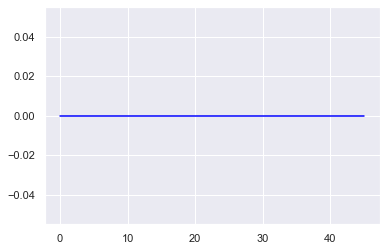

In [7]:
plt.plot(i_beta_22_1, color='blue')

In [8]:
scio.savemat('./i_beta_22_1.mat', {'i_beta_22_1': i_beta_22_1})